In [9]:
import os
import numpy as np
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from learned_tuning.learned_tuning import calculate_learned_tuning_PBE_subsets, calculate_place_field_fidelity_of_learned_tuning
from sklearn.linear_model import LinearRegression


def gausswindow(sigma, halfwidth):
    """
    Compute a Gaussian window function.

    Parameters
    ----------
    sigma : float
        Standard deviation of the Gaussian distribution.
    halfwidth : int
        Half the length of the window.

    Returns
    -------
    win : numpy.ndarray
        The Gaussian window function.

    """
    mu = 0
    x = np.arange(mu - halfwidth, mu + halfwidth + 1)
    y = np.zeros(x.shape)
    
    for i in range(len(x)):
        y[i] = (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-(x[i] - mu)**2 / (2*sigma**2))
    
    win = y/np.sum(y)
    
    return win


z_score = lambda x:(x-np.nanmean(x)) /np.std(x)
normalize_to_max = lambda x:(x/max(x))


main_dir = '/home/kouroshmaboudi/Documents/Learned_tuning_Python/Datasets/'
rr = os.listdir(main_dir)

current_sessions = [x for x in range(8, 11)] # 8: RatU, 9: RatV-NSD1, 10: RatV-NSD3
number_of_sessions = len(current_sessions)

epoch_names = ['pre', 'maze', 'post', 'post_late', 'maze_theta', 'remaze_theta'] # combination of behavioral epoch and sleep/wake state

num_units = np.empty((number_of_sessions,), dtype=int)
each_unit_session_number = np.empty((number_of_sessions,), dtype=object) # to keep track of session identity for each unit when we pool together and sort the units from diferent sessions

spatial_tunings_maze = np.empty((number_of_sessions,), dtype=object) # spatial tunings on MAZE
spatial_tunings_remaze = np.empty((number_of_sessions,), dtype=object) # spatial tunings on reMAZE

spatial_tuning_feature = np.empty((number_of_sessions,), dtype=object) # spatial information of neurons on MAZE

learned_tunings = np.empty((number_of_sessions,), dtype=object)
learned_tunings_place_field_corr = np.empty((number_of_sessions,), dtype=object)
learned_tunings_specificity = np.empty((number_of_sessions,), dtype=object)
post_learned_tunings_stability = np.empty((number_of_sessions,), dtype=object)

remaze_post_learned_tunings_correlation = np.empty((number_of_sessions,), dtype=object)
remaze_maze_learned_tunings_correlation = np.empty((number_of_sessions,), dtype=object)


gw = gausswindow(3, 9) # for smoothing the tunings 
flag = 1

for session_idx in range(number_of_sessions):
    session_number = current_sessions[session_idx]
    session_name = rr[session_number]
    session_dataset_path = os.path.join(main_dir, session_name)

    """
    spatial tunings during MAZE and reMAZE
    """

    spikes_pyr = loadmat(os.path.join(session_dataset_path, session_name + '.spikes_for_python.mat'))['spikes_pyr']

    
    num_units_total = spikes_pyr["spatialTuning_smoothed"][0].shape[0]
    num_pos_bins = spikes_pyr["spatialTuning_smoothed"][0][0]['uni'][0][0].size

    
    spikes = []; # spike data and place field info of each unit

    # attributes = list(spikes_pyr.dtype.names) % if we want to work on all variable in the imported .mat data structure
    running_directions = {'LR', 'RL', 'uni'}
    other_attributes   = {'spike_times', 'shank_id','cluster_id'}

    iter = 0
    for unit in range(num_units_total):
        
        # Create dictionaries for each unit and store the matrices
        unit_spikes = dict()
        
        unit_spikes['place_fields_maze']  = {}
        unit_spikes['peak_pos_bins_remaze'] = {}
        unit_spikes['place_fields_remaze']  = {}
        unit_spikes['peak_pos_bins_remaze'] = {}

        for direction in running_directions:
            try:
                unit_spikes['place_fields_maze'][direction] = spikes_pyr["spatialTuning_smoothed"][0][unit][direction][0][0].reshape(num_pos_bins) 
                unit_spikes['peak_pos_bins_remaze'][direction] = spikes_pyr['peakPosBin'][0][unit][direction][0][0][0][0]

                unit_spikes['place_fields_remaze'][direction] = spikes_pyr["spatialTuning_smoothed_re"][0][unit][direction][0][0].reshape(num_pos_bins) 
                unit_spikes['peak_pos_bins_remaze'][direction] = spikes_pyr['peakPosBin_re'][0][unit][direction][0][0][0][0]


            except ValueError:
                if iter == 0:
                    print("This session has only one running direction")
                iter += 1


        unit_spikes['spike_times'] = spikes_pyr['time'][0][unit]
        unit_spikes['shank_id']    = spikes_pyr['id'][0][unit][0][0]
        unit_spikes['cluster_id']  = spikes_pyr['id'][0][unit][0][1]

        spikes.append(unit_spikes) 


    """
    Learned tunings during different epochs
    """
    
    # Load .mat file
    mat_file = loadmat(os.path.join(session_dataset_path, session_name + '.assemblyTunings_allPBEs_Lthresh1e_3.mat'))
    
    # active units
    active_units_post = mat_file["activeUnits"]["post"].item().reshape([-1])
    active_units_post = active_units_post - 1 # to account for python zero indexing
    num_units[session_idx] = len(active_units_post)

    # loading the learned tunings from differnet .mat sources
    learned_tunings_curr_session = dict()
    
    
    # PRE, MAZE, POST
    # for epoch in [0, 2]: # PRE and POST
    #     curr_epoch = epoch_names[epoch]
    #     learned_tunings_curr_session[curr_epoch] = mat_file["assemblyTunings"][curr_epoch].item()['data'].item()
    
    learned_tunings_curr_session['maze'] = mat_file["assemblyTunings"]['run'].item()['data'].item()



    # if we instead use learned tunings limited to NREM periods
    filename = f'{session_name}.learned_tunings_NREM_vs_QW.npy'
    file_path = os.path.join(session_dataset_path, filename)
    learned_tunings_NREM_vs_QW = np.load(file_path, allow_pickle = True).item()

    learned_tunings_curr_session['pre'] = learned_tunings_NREM_vs_QW['PRE']['learned_tunings_NREM']
    learned_tunings_curr_session['post'] = learned_tunings_NREM_vs_QW['POST']['learned_tunings_NREM']


    # late POST
    mat_file = loadmat(os.path.join(session_dataset_path, session_name + '.assemblyTunings_allPBEs_last4hoursPOST.mat'))
    learned_tunings_curr_session['post_late'] = mat_file["assemblyTunings"]['post'].item()['data'].item()



    # MAZE theta learned tunings
    mat_file = loadmat(os.path.join(session_dataset_path, session_name + '.assemblyTunings_activeRun_binDur0.02.mat'))
    learned_tunings_curr_session['maze_theta'] = mat_file['learnedTunings']


    #REMAZE theta learned tunings
    mat_file = loadmat(os.path.join(session_dataset_path, session_name + '.assemblyTunings_remaze_stricterThetaDetection.mat'))
    learned_tunings_curr_session['remaze_theta'] = mat_file['learnedTunings']


    
    interp_pos_bins = np.linspace(0, num_pos_bins, 200)
    num_pos_bins_interp = len(interp_pos_bins)


    spatial_tunings_maze[session_idx] = np.zeros((num_units_total, num_pos_bins_interp))
    spatial_tunings_remaze[session_idx] = np.zeros((num_units_total, num_pos_bins_interp))

    for unit in range(len(spikes)):

        spatial_tuning_maze_curr_unit = spikes[unit]['place_fields_maze']['uni']
        spatial_tuning_maze_curr_unit = np.interp(interp_pos_bins, np.arange(1, num_pos_bins+1), spatial_tuning_maze_curr_unit)

        """
        Normalize the spatial tunings; zscoring (for multiple regression analysis), or set the max amplitude to one (for plotting the heatmaps)
        """

        spatial_tunings_maze[session_idx][unit] = z_score(spatial_tuning_maze_curr_unit)
        # spatial_tunings_maze[session_idx][unit] = normalize_to_max(spatial_tunings_maze[session_idx][unit]) 


        # reMAZE spatial tunings (all session except RatS with animal's positon on reMAZE recorded)
        if session_number in range(8, 11):  # RatU_Day2, RatV_Day1, RatV_day3
            
            spatial_tuning_remaze_curr_unit = spikes[unit]['place_fields_remaze']['uni']
            spatial_tuning_remaze_curr_unit = np.interp(interp_pos_bins, np.arange(1, num_pos_bins+1), spatial_tuning_remaze_curr_unit)
            spatial_tunings_remaze[session_idx][unit] = z_score(spatial_tuning_remaze_curr_unit) # Normalization similar to what done for MAZE spatial tunings
            # spatial_tunings_remaze[session_idx][unit] = normalize_to_max(spatial_tunings_remaze[session_idx][unit])

    

    spatial_tunings_maze[session_idx] = spatial_tunings_maze[session_idx][active_units_post]
    spatial_tunings_remaze[session_idx] = spatial_tunings_remaze[session_idx][active_units_post]


    learned_tunings[session_idx] = dict()
    learned_tunings_place_field_corr[session_idx] = dict()
    num_shuffles = 10000
    for epoch, epoch_name in enumerate(epoch_names):

        learned_tunings[session_idx][epoch_name] = np.full((num_units[session_idx].item(), num_pos_bins_interp), np.nan)

        for unit in range(num_units[session_idx].item()):
            curr_unit_learned_tuning = learned_tunings_curr_session[epoch_name][active_units_post[unit]].reshape(num_pos_bins)
            curr_unit_learned_tuning = np.interp(interp_pos_bins, np.arange(1, num_pos_bins+1), curr_unit_learned_tuning)
            curr_unit_learned_tuning[np.isnan(curr_unit_learned_tuning)] = 0

            # An additional smoothing of the learned tunings during the sleep epochs
            if epoch in range(1,5): # PRE, MAZE, POST, or latePOST
                curr_unit_learned_tuning = np.convolve(curr_unit_learned_tuning, gw, mode='same')

            # Normalize
            learned_tunings[session_idx][epoch_name][unit] = z_score(curr_unit_learned_tuning)

        # recalculate the correlation between learned tunings and MAZE place fields
        learned_tunings_place_field_corr[session_idx][epoch_name], _ = calculate_place_field_fidelity_of_learned_tuning(learned_tunings[session_idx][epoch_name], spatial_tunings_maze[session_idx], num_shuffles)

    each_unit_session_number[session_idx] = np.full((num_units[session_idx],), session_number)

# concatenate place fields from all sessions and sort them according to the peak place field locations
 
spatial_tunings_maze_sessions_concat = np.concatenate(spatial_tunings_maze, axis=0)
place_fields_peak_locations = np.argmax(spatial_tunings_maze_sessions_concat, axis=1)
place_fields_sort_idx = np.argsort(place_fields_peak_locations)

spatial_tunings_maze_sessions_concat = spatial_tunings_maze_sessions_concat[place_fields_sort_idx]


spatial_tunings_remaze_sessions_concat = np.concatenate(spatial_tunings_remaze, axis=0)
spatial_tunings_remaze_sessions_concat = spatial_tunings_remaze_sessions_concat[place_fields_sort_idx]

each_unit_session_number_sessions_concat = np.concatenate(each_unit_session_number, axis=0)
each_unit_session_number_sessions_concat = each_unit_session_number_sessions_concat[place_fields_sort_idx]


place_field_similarity_maze_remaze, _ = calculate_place_field_fidelity_of_learned_tuning(spatial_tunings_remaze_sessions_concat, spatial_tunings_maze_sessions_concat, num_shuffles)

# learned tunings
learned_tunings_sessions_concat = dict.fromkeys(epoch_names)
for epoch, epoch_name in enumerate(epoch_names):
    temp = []
    for session_idx in range(number_of_sessions):
        temp.append(learned_tunings[session_idx][epoch_name])
    learned_tunings_sessions_concat[epoch_name] = np.concatenate(temp, axis = 0)
    learned_tunings_sessions_concat[epoch_name] = learned_tunings_sessions_concat[epoch_name][place_fields_sort_idx]



learned_tunings_place_field_corr_sessions_concat = dict.fromkeys(epoch_names)
for epoch, epoch_name in enumerate(epoch_names):
    temp = []
    for session_idx in range(number_of_sessions):
        temp.append(learned_tunings_place_field_corr[session_idx][epoch_name])
    learned_tunings_place_field_corr_sessions_concat[epoch_name] = np.concatenate(temp, axis = 0)
    learned_tunings_place_field_corr_sessions_concat[epoch_name] = learned_tunings_place_field_corr_sessions_concat[epoch_name][place_fields_sort_idx]



/tmp/ipykernel_147692/1755060631.py:39: RuntimeWarning: invalid value encountered in divide
  z_score = lambda x:(x-np.nanmean(x)) /np.std(x)


### Multiple regression to analyze the extent to which the learned tunings calculated during each epoch predicts the REMAZE place fields

In [16]:
DV = spatial_tunings_remaze_sessions_concat # dependent variable 
#DV = learned_tunings_sessions_concat['remaze_theta']  

average_Y  = np.nanmean(np.concatenate([learned_tunings_sessions_concat['pre'] ,learned_tunings_sessions_concat['post']], axis = 0), axis = 0)
average_Y  = (average_Y - np.nanmean(average_Y))/np.nanstd(average_Y)
background = np.tile(average_Y, [DV.size // average_Y.size, 1])

predictors       = np.concatenate(
    (background.flatten()[:, np.newaxis],
     learned_tunings_sessions_concat['pre'].flatten()[:, np.newaxis], 
     spatial_tunings_maze_sessions_concat.flatten()[:, np.newaxis], 
     learned_tunings_sessions_concat['maze_theta'].flatten()[:, np.newaxis], 
    #  learned_tunings_sessions_concat['maze'].flatten()[:, np.newaxis], 
     learned_tunings_sessions_concat['post'].flatten()[:, np.newaxis],
     learned_tunings_sessions_concat['post_late'].flatten()[:, np.newaxis]),
     axis=1)
       

predictor_labels = [ 
    'average LT', 
    'PRE LTs',
    'MAZE PFs',
    'MAZE theta LTs',
    'MAZE ripple LTs',
    'POST LTs',
    'latePOST LTs'
] # add 'intercept' to the labels for plotting


num_predictors = len(predictor_labels)


non_nan_idx = np.where(~np.isnan(DV.flatten()) & ~np.isnan(np.sum(predictors, axis = 1)))[0]

lm     = LinearRegression().fit(predictors[non_nan_idx], DV.flatten()[non_nan_idx])
r2     = lm.score(predictors[non_nan_idx], DV.flatten()[non_nan_idx])
coeffs = lm.coef_
intercept = lm.intercept_

# comapring the R^2 and regression coefficients to shuffles
num_shuffles = 1000

r2_shuffle     = np.zeros(num_shuffles)
coeffs_shuffle = np.zeros((num_predictors, num_shuffles))

for shuffle_idx in range(num_shuffles):
    DV_randomized = DV[np.random.permutation(DV.shape[0]), :] # randomizing the units indices in the dependent variable (e.g., REMAZE place fields)

    non_nan_idx = np.where(~np.isnan(DV_randomized.flatten()) & ~np.isnan(np.sum(predictors, axis = 1)))[0]

    shuffle_lm    = LinearRegression().fit(predictors[non_nan_idx], DV_randomized.flatten()[non_nan_idx])
    r2_shuffle[shuffle_idx]        = shuffle_lm.score(predictors[non_nan_idx], DV_randomized.flatten()[non_nan_idx])
    coeffs_shuffle[:, shuffle_idx] = shuffle_lm.coef_

p_r2     = (r2 < r2_shuffle).sum() / num_shuffles
p_coeffs = (coeffs.reshape(-1, 1) < coeffs_shuffle).sum(axis=1) / num_shuffles



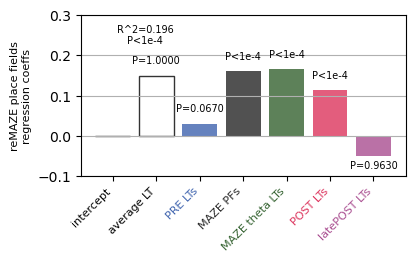

In [17]:
def get_pval_statement(pvalue):
    if pvalue < 0.0001:
        pvalue_statement = 'P<1e-4'
    else:
        pvalue_statement = f'P={pvalue:.4f}'
    return pvalue_statement


plotheight = 200
plotwidth  = 50 * num_predictors
fontsize   = 8

f = plt.figure()
f.clear()
f.set_size_inches([plotwidth/72, plotheight/72])
f.subplots_adjust(left=0.2, right=.98, bottom=0.3)
ax = f.add_subplot(1,1,1)

colors = [
    'black', # intercept
    'black', # background
    [0.2431, 0.3882, 0.6824], # PRE learned tunings
    [0.1490, 0.1490,  0.1490], # MAZE place fields
    [0.2039, 0.3843, 0.1882], # MAZE theta learned tunings
    [0.0627, 0.5451, 0.2667], # MAZE ripple learned tunings
    [0.8627, 0.2039, 0.3647], # POST learned tunings
    [0.6627, 0.3039, 0.5647] # late POST learned tunings
    ]

ax.set_yticks([-.1, 0, .1, .2, .3])


h = ax.bar(np.arange(num_predictors+1), np.concatenate([[intercept], coeffs]), align='center', alpha=0.8, linewidth=1, color=colors)
for ih in range(2):
    h[ih].set_facecolor('none')
    h[ih].set_edgecolor('k')
    h[ih].set_linewidth(1)

for ih in range(3,8):
    h[ih].set_edgecolor('none')


for ip in range(0, num_predictors):
    ax.text(ip+1, coeffs[ip]+0.03*np.sign(coeffs[ip]), get_pval_statement(p_coeffs[ip]), fontsize=7, horizontalalignment='center')

ax.text(0.75, 0.25, 'R^2={:.3f}\n{}'.format(r2, get_pval_statement(p_r2)), fontsize=7, horizontalalignment='center', verticalalignment='center')

ax.set_xticks(np.arange(num_predictors+1))
ax.set_xticklabels(np.concatenate([['intercept'], predictor_labels]), fontsize=fontsize, ha='right', va='top')
ax.tick_params(axis = 'x', rotation=45)
for i , label in enumerate(ax.get_xticklabels()):
    label.set_color(colors[i])



ax.set_ylabel('reMAZE place fields\nregression coeffs', fontsize=8)
ax.set_ylim([-0.1, 0.3])
ax.yaxis.grid(True)

filename = 'multiple_regression_remaze_place_fields.svg'
file_path = os.path.join(main_dir, filename)
# plt.savefig(file_path, dpi=300)

plt.show()



In [119]:
np.sign(-5)

-1

In [18]:
coeffs

array([ 0.14916567,  0.02919165,  0.16018718,  0.16490629,  0.11304743,
       -0.05094062])